In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Example: adjust source path to your real path
!cp -r "/content/drive/MyDrive/Clean_braille_words" "/content/Braille_words"


In [ ]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm

# ----------------- Config -----------------
DATA_ROOT = "Braille_words"
IMG_HEIGHT = 64
MAX_IMG_WIDTH = 640
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-3
CHECKPOINT_DIR = "checkpoints_ctc"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ----------------- Utilities: dataset loading -----------------
def find_image_paths_and_labels(root):
    img_paths = []
    labels = []
    for word in sorted(os.listdir(root)):
        word_dir = os.path.join(root, word)
        if not os.path.isdir(word_dir):
            continue
        for fname in os.listdir(word_dir):
            if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
                continue
            img_paths.append(os.path.join(word_dir, fname))
            labels.append(word)
    if not img_paths:
        raise ValueError(f"No images found in {root}")
    return img_paths, labels

def build_vocab_from_labels(label_list):
    chars = set()
    for w in label_list:
        for c in w:
            chars.add(c)
    chars = sorted(list(chars))
    char_to_num = {c: i for i, c in enumerate(chars)}   # 0..N-1
    num_to_char = {i: c for i, c in enumerate(chars)}
    return chars, char_to_num, num_to_char

def preprocess_image(path, img_height=IMG_HEIGHT, max_width=MAX_IMG_WIDTH):
    img = Image.open(path).convert("L")
    w, h = img.size
    new_h = img_height
    new_w = max(1, int(w * (new_h / float(h))))
    img = img.resize((new_w, new_h), Image.LANCZOS)
    arr = np.array(img).astype(np.float32) / 255.0
    arr = arr * 2.0 - 1.0
    if new_w < max_width:
        pad = np.ones((new_h, max_width), dtype=np.float32) * (-1.0)
        pad[:, :new_w] = arr
        arr = pad
    elif new_w > max_width:
        arr = arr[:, :max_width]
    arr = np.expand_dims(arr, -1)
    return arr, new_w

def encode_label(word, char_to_num, max_label_len=32):
    seq = [char_to_num[c] for c in word]
    return np.array(seq, dtype=np.int32)

# ----------------- Prepare dataset lists -----------------
print("Scanning dataset...")
img_paths, labels = find_image_paths_and_labels(DATA_ROOT)
chars, char_to_num, num_to_char = build_vocab_from_labels(labels)
vocab_size = len(chars) + 1
print(f"Detected {len(labels)} images, alphabet size {len(chars)}: {chars}")

data = list(zip(img_paths, labels))
random.shuffle(data)
img_paths, labels = zip(*data)
n = len(img_paths)
n_train = int(0.9 * n)
train_paths, train_labels = img_paths[:n_train], labels[:n_train]
val_paths, val_labels = img_paths[n_train:], labels[n_train:]
print(f"Train: {len(train_paths)} images, Val: {len(val_paths)} images")

max_label_len = max(len(w) for w in labels)
print("Max label length:", max_label_len)

# ----------------- Generator -----------------
def data_generator(paths, labels, char_to_num, batch_size=BATCH_SIZE, shuffle=True):
    n = len(paths)
    idxs = np.arange(n)
    global_max_label = max_label_len
    while True:
        if shuffle:
            np.random.shuffle(idxs)
        for start in range(0, n, batch_size):
            batch_idxs = idxs[start:start+batch_size]
            batch_imgs = []
            batch_labels = []
            input_lengths = []
            label_lengths = []
            for i in batch_idxs:
                arr, actual_w = preprocess_image(paths[i])
                batch_imgs.append(arr.astype(np.float32))
                seq = encode_label(labels[i], char_to_num)
                batch_labels.append(seq)
                input_lengths.append(actual_w)
                label_lengths.append(len(seq))
            X = np.stack(batch_imgs, axis=0)
            labels_padded = np.zeros((len(batch_labels), global_max_label), dtype=np.int32)
            for ii, seq in enumerate(batch_labels):
                L = min(len(seq), global_max_label)
                labels_padded[ii, :L] = seq[:L]
            input_lengths = np.array(input_lengths, dtype=np.int32).reshape(-1, 1)
            label_lengths = np.array(label_lengths, dtype=np.int32).reshape(-1, 1)
            yield (
                {
                    'image_input': X,
                    'labels': labels_padded,
                    'input_length': input_lengths,
                    'label_length': label_lengths
                },
                np.zeros((len(batch_idxs),), dtype=np.float32)
            )

# ----------------- Build CRNN (inference) -----------------
def build_crnn_model(img_h=IMG_HEIGHT, img_w=MAX_IMG_WIDTH, num_chars=len(chars)):
    image_input = layers.Input(shape=(img_h, img_w, 1), name='image_input')
    x = image_input
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
    x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,1), strides=(2,1), padding='valid')(x)
    x = layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2,1), strides=(2,1), padding='valid')(x)

    shape = tf.keras.backend.int_shape(x)
    Hp, Wp, Cp = shape[1], shape[2], shape[3]
    x = layers.Permute((2,1,3))(x)
    x = layers.Reshape((Wp, Hp * Cp))(x)

    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2))(x)

    logits = layers.Dense(num_chars + 1, activation='linear', name='logits')(x)  # last index = blank
    infer_model = Model(inputs=image_input, outputs=logits, name='inference_model')
    return infer_model, Wp

# ----------------------- Trainer (custom train/test step) -----------------------
class CRNNTrainer(tf.keras.Model):
    def __init__(self, infer_model, **kwargs):
        super().__init__(**kwargs)
        self.infer_model = infer_model
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def _dense_to_sparse(self, labels_dense, label_lengths):
        batch_size = tf.shape(labels_dense)[0]
        max_len = tf.shape(labels_dense)[1]
        rng = tf.range(max_len)
        rng = tf.expand_dims(rng, 0)
        rng = tf.tile(rng, [batch_size, 1])
        lengths_tiled = tf.expand_dims(label_lengths, 1)
        mask = tf.less(rng, lengths_tiled)
        coords = tf.where(mask)
        values = tf.gather_nd(labels_dense, coords)
        coords = tf.cast(coords, tf.int64)
        dense_shape = tf.cast(tf.shape(labels_dense), tf.int64)
        sparse = tf.SparseTensor(indices=coords, values=tf.cast(values, tf.int32), dense_shape=dense_shape)
        return sparse

    def compile(self, optimizer, run_eagerly=False, **kwargs):
        super().compile(run_eagerly=run_eagerly, **kwargs)
        self.optimizer = optimizer

    def train_step(self, data):
        inputs, _ = data
        images = tf.convert_to_tensor(inputs['image_input'], dtype=tf.float32)
        labels_dense = tf.convert_to_tensor(inputs['labels'], dtype=tf.int32)
        label_lengths = tf.reshape(tf.convert_to_tensor(inputs['label_length'], dtype=tf.int32), [-1])

        with tf.GradientTape() as tape:
            logits = self.infer_model(images, training=True)   # (B, T, C)
            logits_time_major = tf.transpose(logits, perm=[1, 0, 2])  # (T, B, C)

            static_num_classes = logits.shape[-1]
            if static_num_classes is not None:
                blank_index_val = int(static_num_classes) - 1
            else:
                blank_index_val = tf.shape(logits)[-1] - 1

            sparse_labels = self._dense_to_sparse(labels_dense, label_lengths)
            batch_size = tf.shape(logits)[0]
            time_steps = tf.shape(logits)[1]
            logit_length = tf.fill([batch_size], time_steps)

            loss_vec = tf.nn.ctc_loss(
                labels=sparse_labels,
                logits=logits_time_major,
                label_length=label_lengths,
                logit_length=logit_length,
                logits_time_major=True,
                blank_index=blank_index_val
            )  # (B,)
            loss = tf.reduce_mean(loss_vec)

            extra_losses = getattr(self.infer_model, 'losses', None)
            if extra_losses:
                loss = loss + tf.add_n(extra_losses)

        grads = tape.gradient(loss, self.infer_model.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, 1.0)
        self.optimizer.apply_gradients(zip(grads, self.infer_model.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        inputs, _ = data
        images = tf.convert_to_tensor(inputs['image_input'], dtype=tf.float32)
        labels_dense = tf.convert_to_tensor(inputs['labels'], dtype=tf.int32)
        label_lengths = tf.reshape(tf.convert_to_tensor(inputs['label_length'], dtype=tf.int32), [-1])

        logits = self.infer_model(images, training=False)
        logits_time_major = tf.transpose(logits, perm=[1, 0, 2])

        static_num_classes = logits.shape[-1]
        if static_num_classes is not None:
            blank_index_val = int(static_num_classes) - 1
        else:
            blank_index_val = tf.shape(logits)[-1] - 1

        sparse_labels = self._dense_to_sparse(labels_dense, label_lengths)
        batch_size = tf.shape(logits)[0]
        time_steps = tf.shape(logits)[1]
        logit_length = tf.fill([batch_size], time_steps)

        loss_vec = tf.nn.ctc_loss(
            labels=sparse_labels,
            logits=logits_time_major,
            label_length=label_lengths,
            logit_length=logit_length,
            logits_time_major=True,
            blank_index=blank_index_val
        )
        loss = tf.reduce_mean(loss_vec)

        extra_losses = getattr(self.infer_model, 'losses', None)
        if extra_losses:
            loss = loss + tf.add_n(extra_losses)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# ----------------- Decoding & metrics helpers -----------------
def decode_batch(images_np, infer_model, beam_width=10, top_paths=1):
    """Apply softmax to logits then CTC-decode. Returns list[str] of decoded texts."""
    logits = infer_model.predict(images_np)  # (B, T, C)
    probs = tf.nn.softmax(logits, axis=-1).numpy()
    batch_size = probs.shape[0]
    time_steps = probs.shape[1]
    input_length = np.ones((batch_size,), dtype=np.int32) * time_steps

    decoded, log_prob = tf.keras.backend.ctc_decode(
        probs,
        input_length=input_length,
        greedy=(beam_width == 1),
        beam_width=beam_width,
        top_paths=top_paths
    )
    first = decoded[0]

    if isinstance(first, tf.SparseTensor):
        dense = tf.sparse.to_dense(first, default_value=-1).numpy()
    elif tf.is_tensor(first):
        dense = first.numpy()
    else:
        dense = tf.sparse.to_dense(tf.convert_to_tensor(first), default_value=-1).numpy()

    out_texts = []
    for row in dense:
        chars = []
        for cid in row:
            if cid == -1:
                continue
            if cid >= logits.shape[-1] - 1:
                continue
            cid = int(cid)
            if cid in num_to_char:
                chars.append(num_to_char[cid])
        out_texts.append("".join(chars))
    return out_texts

def levenshtein(a, b):
    if len(a) < len(b):
        return levenshtein(b, a)
    previous_row = list(range(len(b) + 1))
    for i, ca in enumerate(a, start=1):
        current_row = [i]
        for j, cb in enumerate(b, start=1):
            insertions = previous_row[j] + 1
            deletions = current_row[j-1] + 1
            substitutions = previous_row[j-1] + (0 if ca == cb else 1)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def compute_cer(pred, gt):
    if len(gt) == 0:
        return 0.0 if len(pred) == 0 else 1.0
    return levenshtein(pred, gt) / len(gt)

def compute_wer(pred, gt):
    p_tokens = pred.split()
    g_tokens = gt.split()
    if len(g_tokens) == 0:
        return 0.0 if len(p_tokens) == 0 else 1.0
    return levenshtein(p_tokens, g_tokens) / max(1, len(g_tokens))

# ----------------- Accuracy callback (prints examples + metrics) -----------------
class AccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_paths, val_labels, infer_model, num_to_char,
                 batch_size=32, max_eval=256, beam_width=10):
        super().__init__()
        self.val_paths = val_paths
        self.val_labels = val_labels
        self.infer_model = infer_model
        self.num_to_char = num_to_char
        self.batch_size = batch_size
        self.max_eval = max_eval
        self.beam_width = beam_width

    def on_epoch_end(self, epoch, logs=None):
        n = min(len(self.val_paths), self.max_eval)
        idxs = np.random.choice(len(self.val_paths), n, replace=False)

        total_cer = 0.0
        total_wer = 0.0
        examples = []

        for i0 in range(0, n, self.batch_size):
            bidx = idxs[i0:i0+self.batch_size]
            batch_imgs, batch_gts = [], []
            for ii in bidx:
                img, _ = preprocess_image(self.val_paths[ii])
                batch_imgs.append(img)
                batch_gts.append(self.val_labels[ii])
            X = np.stack(batch_imgs, axis=0)
            preds = decode_batch(X, self.infer_model, beam_width=self.beam_width)
            for p, g in zip(preds, batch_gts):
                total_cer += compute_cer(p, g)
                total_wer += compute_wer(p, g)
                if len(examples) < 8:
                    examples.append((g, p))

        avg_cer = total_cer / n
        avg_wer = total_wer / n
        char_acc = 1 - avg_cer
        word_acc = 1 - avg_wer

        print(f"\nEpoch {epoch+1}: Char_Acc={char_acc:.4f}, Word_Acc={word_acc:.4f}")
        print(" Some val examples (GT -> Pred):")
        for gt, pr in examples:
            print("  ", gt, "->", pr)

        if logs is not None:
            logs["char_accuracy"] = float(char_acc)
            logs["word_accuracy"] = float(word_acc)

# ----------------- Build and run training -----------------
tf.keras.backend.clear_session()
infer_model, TIME_STEPS = build_crnn_model()
print("TIME_STEPS (sequence length after CNN):", TIME_STEPS)

trainer = CRNNTrainer(infer_model)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
trainer.compile(optimizer=opt)

train_gen = data_generator(train_paths, train_labels, char_to_num, batch_size=BATCH_SIZE, shuffle=True)
val_gen   = data_generator(val_paths, val_labels, char_to_num, batch_size=BATCH_SIZE, shuffle=False)

steps_per_epoch = max(1, len(train_paths)//BATCH_SIZE)
validation_steps = max(1, len(val_paths)//BATCH_SIZE)

checkpoint_cb = ModelCheckpoint(os.path.join(CHECKPOINT_DIR, "best_ctc.keras"),
                                monitor='loss', save_best_only=True, save_weights_only=False)
early_cb = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)

acc_cb = AccuracyCallback(val_paths, val_labels, infer_model, num_to_char, batch_size=BATCH_SIZE, max_eval=256, beam_width=12)

# include eval_cb here if you previously defined it
if 'eval_cb' in globals() and eval_cb is not None:
    callbacks = [checkpoint_cb, early_cb, eval_cb, acc_cb]
else:
    callbacks = [checkpoint_cb, early_cb, acc_cb]

history = trainer.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# After training finishes
# Save just the inference (pure CRNN) model, not the trainer wrapper

infer_model.save(os.path.join(CHECKPOINT_DIR, "best_ctc_inference.keras"))
print("Saved inference-only model to:", os.path.join(CHECKPOINT_DIR, "best_ctc_inference.keras"))


Scanning dataset...
Detected 15919 images, alphabet size 26: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Train: 14327 images, Val: 1592 images
Max label length: 10
TIME_STEPS (sequence length after CNN): 160
Epoch 1/15
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 26.2606

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step

Epoch 1: Char_Acc=-9.8261, Word_Acc=0.0000
 Some val examples (GT -> Pred):
   DOG -> FGFORKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKST
   GOOD -> BHOKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKST
   BOX -> WHIOUOUMUKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKS
   BAG -> BACACACFCFTJTJKHKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKS
   BOOK -> BGOFOSOIMYTHTWTKTKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKST
   OVER -> WOTHGHKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKST
   GOING -> BFLTHKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKST
   BUS -> BAICTWTWTBACAKNKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKST
447/447 ━━━━━━━━━━━━━━━━━━━━ 132s 265ms/step - loss: 26.2340 - val_loss: 292.3714 - char_accuracy: -9.8261

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_confusion_matrix(val_paths, val_labels, infer_model, num_to_char, char_to_num,
                              max_samples=500, batch_size=32):

    idxs = np.random.choice(len(val_paths), min(len(val_paths), max_samples), replace=False)

    all_true_chars = []
    all_pred_chars = []

    for i in range(0, len(idxs), batch_size):
        batch_idxs = idxs[i:i+batch_size]

        batch_imgs = []
        batch_gts = []

        for ii in batch_idxs:
            img, _ = preprocess_image(val_paths[ii])
            batch_imgs.append(img)
            batch_gts.append(val_labels[ii])

        X = np.stack(batch_imgs, axis=0)

        preds = decode_batch(X, infer_model, beam_width=10)

        for pred, gt in zip(preds, batch_gts):

            # match length to compare
            min_len = min(len(pred), len(gt))

            for p, g in zip(pred[:min_len], gt[:min_len]):
                all_pred_chars.append(p)
                all_true_chars.append(g)

    labels = sorted(list(char_to_num.keys()))

    cm = confusion_matrix(all_true_chars, all_pred_chars, labels=labels)

    # plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels,
                cmap="Blues", annot=False)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Character Confusion Matrix")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(all_true_chars, all_pred_chars))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


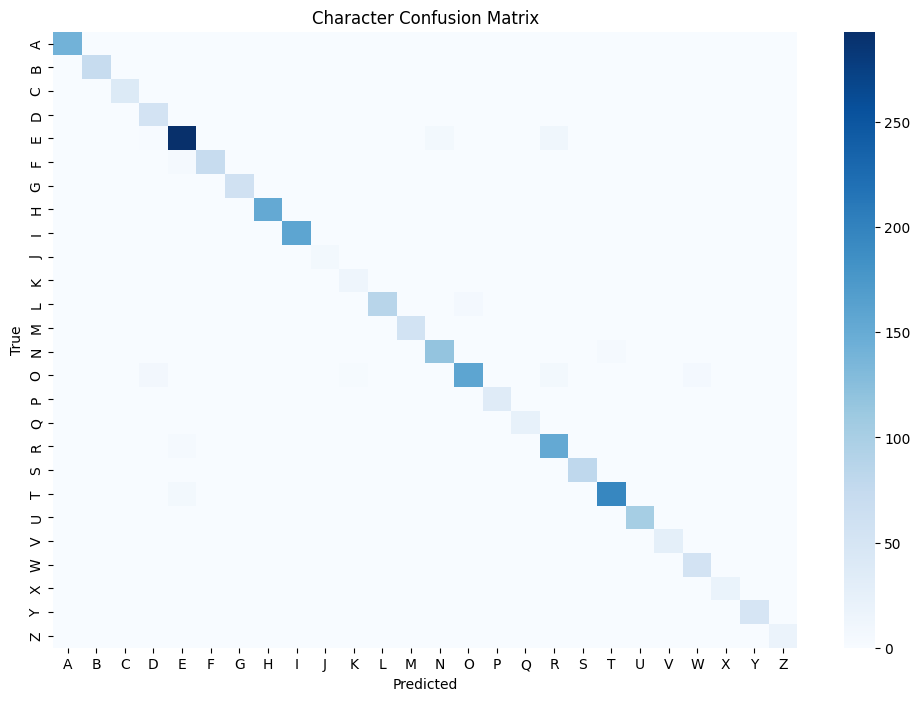


Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       141
           B       1.00      1.00      1.00        71
           C       1.00      1.00      1.00        39
           D       0.83      1.00      0.91        54
           E       0.95      0.93      0.94       316
           F       1.00      0.93      0.97        76
           G       1.00      1.00      1.00        59
           H       1.00      1.00      1.00       153
           I       1.00      1.00      1.00       158
           J       1.00      1.00      1.00         8
           K       0.82      1.00      0.90        14
           L       1.00      0.93      0.97        92
           M       1.00      1.00      1.00        55
           N       0.94      0.96      0.95       122
           O       0.96      0.86      0.91       183
           P       1.00      1.00      1.00        36
           Q       1.00      1.00      1.00        24
  

In [ ]:
evaluate_confusion_matrix(
    val_paths,
    val_labels,
    infer_model,
    num_to_char,
    char_to_num
)


In [ ]:
from sklearn.metrics import accuracy_score

def word_level_accuracy(val_paths, val_labels, infer_model, max_samples=500):

    idxs = np.random.choice(len(val_paths), min(len(val_paths), max_samples), replace=False)

    batch_imgs = []
    gts = []

    for ii in idxs:
        img, _ = preprocess_image(val_paths[ii])
        batch_imgs.append(img)
        gts.append(val_labels[ii])

    X = np.stack(batch_imgs)

    preds = decode_batch(X, infer_model)

    acc = accuracy_score(gts, preds)

    print("Word-level accuracy:", acc)


In [ ]:
word_level_accuracy(val_paths, val_labels, infer_model)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Word-level accuracy: 0.902


In [ ]:
import tensorflow as tf
import os

SAVE_PATH = os.path.join(CHECKPOINT_DIR, "best_ctc_inference_tf.keras")

# Case 1: infer_model exists (it does!)
if 'infer_model' in globals():
    print("✓ Found infer_model. Saving using tf.keras...")
    infer_model.save(SAVE_PATH)
    print("✓ Saved tf.keras-compatible model to:", SAVE_PATH)

# Case 2: model stored inside trainer
elif 'trainer' in globals() and hasattr(trainer, 'infer_model'):
    print("✓ Found trainer.infer_model. Saving using tf.keras...")
    trainer.infer_model.save(SAVE_PATH)
    print("✓ Saved tf.keras-compatible model to:", SAVE_PATH)

else:
    print("✗ ERROR: No infer_model found. Cannot save.")


✓ Found infer_model. Saving using tf.keras...
✓ Saved tf.keras-compatible model to: checkpoints_ctc/best_ctc_inference_tf.keras


In [ ]:
import csv
from PIL import Image, ImageDraw, ImageFont
from collections import defaultdict
import numpy as np
import os
from tqdm import tqdm

# reuse your compute_cer/compute_wer and preprocess_image/decode_batch/infer_model

def _guess_gt_from_filename(fname):
    stem = os.path.splitext(fname)[0]
    if '_' in stem:
        return stem.split('_')[0]
    return stem

def predict_unseen_folder(
    unseen_dir,
    out_csv = None,
    gt_from_filename=True,
    gt_map=None,
    beam_width=12,
    save_overlay=False,
    out_dir = None,
    max_examples=None,
    batch_size=None
):
    """
    Predict on images in `unseen_dir`. Writes CSV with columns (filename, gt, pred, cer, wer).
    Returns list of (filename, gt, pred, cer, wer).
    """
    # sanity defaults (pull from notebook globals if available)
    if out_dir is None:
        out_dir = globals().get("CHECKPOINT_DIR", ".")
    if out_csv is None:
        out_csv = os.path.join(out_dir, "unseen_predictions.csv")
    if batch_size is None:
        batch_size = globals().get("BATCH_SIZE", 32)

    if not os.path.isdir(unseen_dir):
        raise ValueError(f"unseen_dir does not exist or is not a directory: {unseen_dir}")

    os.makedirs(out_dir, exist_ok=True)
    overlay_dir = os.path.join(out_dir, "overlay")
    if save_overlay:
        os.makedirs(overlay_dir, exist_ok=True)

    img_files = [f for f in sorted(os.listdir(unseen_dir))
                 if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    if len(img_files) == 0:
        print("No image files found in", unseen_dir)
        return []

    if max_examples:
        img_files = img_files[:max_examples]

    results = []

    # batch loop with progress bar
    for i0 in tqdm(range(0, len(img_files), batch_size), desc="Predict batches"):
        batch_files = img_files[i0:i0+batch_size]
        batch_imgs = []
        gts = []
        for fname in batch_files:
            p = os.path.join(unseen_dir, fname)
            try:
                img_arr, _w = preprocess_image(p)   # uses your preprocess_image
            except Exception as e:
                print(f"Skipping {fname}: preprocess_image error: {e}")
                continue
            batch_imgs.append(img_arr)
            if gt_map and fname in gt_map:
                gts.append(gt_map[fname])
            elif gt_from_filename:
                gts.append(_guess_gt_from_filename(fname))
            else:
                gts.append("")

        if len(batch_imgs) == 0:
            continue

        X = np.stack(batch_imgs, axis=0)

        # decode in try/except so a batch error doesn't stop everything
        try:
            preds = decode_batch(X, infer_model, beam_width=beam_width)
        except Exception as e:
            print(f"decode_batch failed on batch starting at {i0}: {e}")
            # fallback: try greedy decode
            try:
                preds = decode_batch(X, infer_model, beam_width=1)
                print("Used fallback greedy decode for this batch.")
            except Exception as e2:
                print("Fallback decode also failed; skipping these images. Error:", e2)
                continue

        for fname, gt, pred, img_arr in zip(batch_files, gts, preds, batch_imgs):
            cer = compute_cer(pred, gt) if gt != "" else None
            wer = compute_wer(pred, gt) if gt != "" else None
            results.append((fname, gt, pred, cer, wer))

            if save_overlay:
                # create overlay image and save (convert back to 0-255)
                arr_disp = ((img_arr.squeeze() + 1.0) / 2.0 * 255.0).clip(0,255).astype(np.uint8)
                pil = Image.fromarray(arr_disp).convert("RGB")
                draw = ImageDraw.Draw(pil)
                try:
                    font = ImageFont.truetype("DejaVuSans-Bold.ttf", 18)
                except Exception:
                    font = ImageFont.load_default()
                text = f"GT:{gt}  PRED:{pred}"
                draw.text((4,4), text, fill=(255,0,0), font=font)
                pil.save(os.path.join(overlay_dir, fname))

    # write CSV
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["filename","gt","prediction","cer","wer"])
        for r in results:
            writer.writerow([r[0], r[1], r[2], "" if r[3] is None else f"{r[3]:.4f}", "" if r[4] is None else f"{r[4]:.4f}"])
    print(f"Wrote {len(results)} predictions to {out_csv}")
    if save_overlay:
        print(f"Saved overlay images to: {overlay_dir}")

    # Print snippet & worst examples
    print("\nSome predictions (first 20):")
    for r in results[:20]:
        print(f" {r[0]:30s} | GT: {r[1]:12s} -> PRED: {r[2]:12s} | CER: {('NA' if r[3] is None else f'{r[3]:.3f}')}")

    scored = [r for r in results if r[3] is not None]
    if scored:
        scored_sorted = sorted(scored, key=lambda x: x[3], reverse=True)
        print("\nWorst 10 by CER:")
        for r in scored_sorted[:10]:
            print(f" {r[0]:30s} | GT: {r[1]:12s} -> PRED: {r[2]:12s} | CER: {r[3]:.3f}")

    return results

# ---------- Single-image helper (uses same decode and preprocess) ----------
def predict_single_image(img_path, beam_width=10, show_image=False):
    """
    Predict single image and return predicted text. Optionally show the image.
    """
    if not os.path.exists(img_path):
        raise ValueError("Image not found: " + img_path)
    img_arr, _ = preprocess_image(img_path)
    X = np.expand_dims(img_arr, axis=0)
    preds = decode_batch(X, infer_model, beam_width=beam_width)
    pred_text = preds[0]
    print(f"Predicted: {pred_text}")
    if show_image:
        import matplotlib.pyplot as plt
        pil = Image.open(img_path).convert("L")
        plt.imshow(pil, cmap="gray")
        plt.title(f"Pred: {pred_text}")
        plt.axis("off")
        plt.show()
    return pred_text


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted: MOUSE


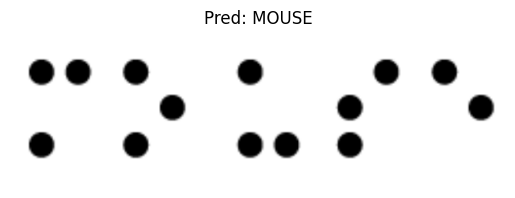

In [ ]:
pred = predict_single_image("/content/Screenshot 2025-12-09 213814.png", beam_width=8, show_image=True)


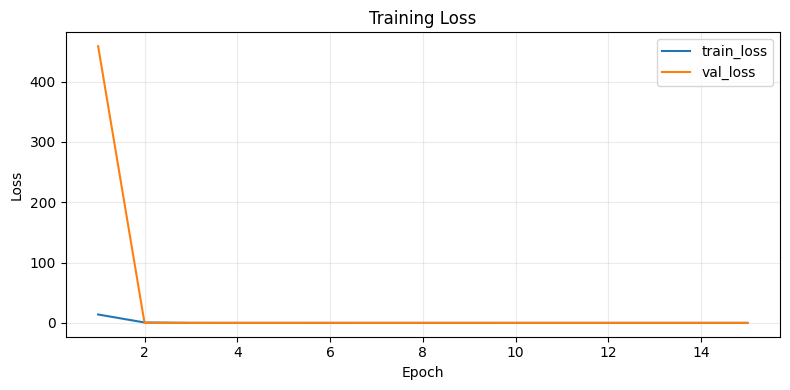

Saved loss plot to: checkpoints_ctc/loss_plot.png


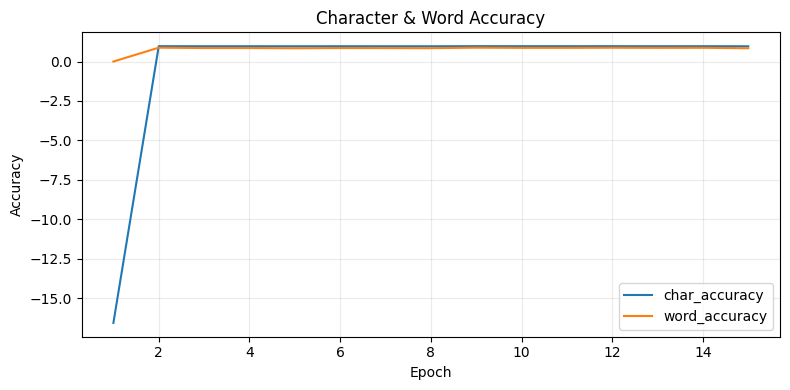

Saved accuracy plot to: checkpoints_ctc/accuracy_plot.png


In [ ]:
import matplotlib.pyplot as plt
import os

def plot_loss_and_accuracy_from_history(history, out_dir=CHECKPOINT_DIR):
    """
    Plots train/val loss and char/word accuracy from a Keras history-like object.
    Saves PNGs to out_dir and also shows them inline.
    """
    os.makedirs(out_dir, exist_ok=True)

    # --- Loss plot ---
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', None)  # may be None for our custom trainer
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epochs, loss, label='train_loss')
    if val_loss is not None:
        plt.plot(epochs, val_loss, label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(alpha=0.25)
    loss_path = os.path.join(out_dir, 'loss_plot.png')
    plt.tight_layout()
    plt.savefig(loss_path, dpi=150)
    plt.show()
    plt.close()
    print("Saved loss plot to:", loss_path)

    # --- Accuracy plot (char & word) ---
    # There are two possible sources:
    # 1) metrics recorded into history.history as 'char_accuracy' / 'word_accuracy'
    # 2) you may have an eval callback that kept its own lists (e.g. eval_cb.history)
    char_acc = history.history.get('char_accuracy', None)
    word_acc = history.history.get('word_accuracy', None)

    # Fallback: try to find in a global eval_cb if it exists and has history dict
    if (char_acc is None or word_acc is None) and 'eval_cb' in globals() and getattr(eval_cb, 'history', None):
        # eval_cb.history expected like {'val_cer': [...], 'val_wer': [...]}
        ev = eval_cb.history
        # if eval_cb stored CER/WER we can convert to accuracy: char_acc = 1 - val_cer
        if 'val_cer' in ev and 'val_wer' in ev:
            char_acc = [1 - v for v in ev['val_cer']]
            word_acc = [1 - v for v in ev['val_wer']]

    # Another fallback: some users store metrics in a custom callback like acc_cb.history
    if (char_acc is None or word_acc is None) and 'acc_cb' in globals() and hasattr(acc_cb, 'history'):
        ac_hist = getattr(acc_cb, 'history')
        if isinstance(ac_hist, dict) and 'char_accuracy' in ac_hist and 'word_accuracy' in ac_hist:
            char_acc = ac_hist['char_accuracy']
            word_acc = ac_hist['word_accuracy']

    if char_acc is None or word_acc is None:
        print("No char_accuracy/word_accuracy found in history. If your AccuracyCallback stores its own lists, "
              "make sure it exposes them as acc_cb.history = {'char_accuracy': [...], 'word_accuracy': [...]} or "
              "that history.history contains 'char_accuracy'/'word_accuracy'.")
        return

    epochs_acc = range(1, len(char_acc) + 1)
    plt.figure(figsize=(8,4))
    plt.plot(epochs_acc, char_acc, label='char_accuracy')
    plt.plot(epochs_acc, word_acc, label='word_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Character & Word Accuracy')
    plt.legend()
    plt.grid(alpha=0.25)
    acc_path = os.path.join(out_dir, 'accuracy_plot.png')
    plt.tight_layout()
    plt.savefig(acc_path, dpi=150)
    plt.show()
    plt.close()
    print("Saved accuracy plot to:", acc_path)


# Call the plotting function with the trainer.fit() return value `history`
plot_loss_and_accuracy_from_history(history, out_dir=CHECKPOINT_DIR)
